<a href="https://colab.research.google.com/github/miaohall/Phishing-Scam-Detector-Analysis/blob/main/DS110_FinalProj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#IMPORTS
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import tree

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Phising_Detection_Dataset.csv to Phising_Detection_Dataset (3).csv


In [ ]:
df = pd.read_csv('Phising_Detection_Dataset.csv')

In [ ]:
#cleaning
#drop rows with missing values in phishing column
df.dropna(subset=['Phising'], inplace=True)
#remove duplicate rows
df.drop_duplicates(inplace=True)

#all columns
print(df.columns)

Index(['Unnamed: 0', 'NumDots', 'UrlLength', 'NumDash', 'AtSymbol',
       'IpAddress', 'HttpsInHostname', 'PathLevel', 'PathLength',
       'NumNumericChars', 'Phising'],
      dtype='object')


EXPLORATORY STATS BELOW


In [ ]:
#t-test
#num of numeric chars & non phishing/phishing
chars_phishing = df.loc[df['Phising'] == 1, 'NumNumericChars'] #all rows in num of numeric chars column that are phishing
chars_non_phishing = df.loc[df['Phising'] == 0, 'NumNumericChars'] #all rows in num of numeric chars column that are non phishing

min_samp_size = min(len(chars_phishing), len(chars_non_phishing))

#because there is significantly more non-phishing data, take a random sub sample of each group so there is an equal amount of data being compared
subsamp_phishing = np.random.choice(chars_phishing, size = min_samp_size, replace = False)
subsamp_non_phishing = np.random.choice(chars_non_phishing, size = min_samp_size, replace = False)

t_val, p_val = sp.stats.ttest_ind(subsamp_phishing, subsamp_non_phishing)
print(f"p-val - num numeric chars: {p_val}") #p val varies but is always less than 0.05 when testing

p-val - num numeric chars: 0.006642673369247946


In [ ]:
#correlations (for phishing data)

#use spearman correlation matrix to create table of correlations between every column

#make subset
phish_data = df[df['Phising'] == 1]

features = phish_data.columns[1:10] #exclude first column and last
phish_corr = phish_data[features].corr(method = 'spearman')
print("Correlations for phishing data:")
phish_corr

Correlations for phishing data:


,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars
NumDots,1.000000,0.544684,0.100006,0.083606,0.094021,-0.042764,0.392495,0.462851,0.188339
UrlLength,0.544684,1.000000,0.387031,0.116977,0.063687,0.234584,0.570369,0.616904,0.402239
NumDash,0.100006,0.387031,1.000000,0.070080,-0.000886,0.126999,0.097634,0.248365,0.186051
AtSymbol,0.083606,0.116977,0.070080,1.000000,0.000746,0.123552,0.045921,0.029225,0.033335
IpAddress,0.094021,0.063687,-0.000886,0.000746,1.000000,-0.010492,0.028357,-0.004674,0.107178
HttpsInHostname,-0.042764,0.234584,0.126999,0.123552,-0.010492,1.000000,-0.011346,-0.083785,0.131737
PathLevel,0.392495,0.570369,0.097634,0.045921,0.028357,-0.011346,1.000000,0.714429,0.215258
PathLength,0.462851,0.616904,0.248365,0.029225,-0.004674,-0.083785,0.714429,1.000000,0.211096
NumNumericChars,0.188339,0.402239,0.186051,0.033335,0.107178,0.131737,0.215258,0.211096,1.000000


In [ ]:
#correlations (for non-phishing data)

#use spearman correlation matrix to create table of correlations between every column

#make subset
non_phish_data = df[df['Phising'] == 0]

features = non_phish_data.columns[1:10]
non_phish_corr = non_phish_data[features].corr(method = 'spearman')
print("Correlations for non-phishing data")
non_phish_corr

Correlations for non-phishing data


,NumDots,UrlLength,NumDash,AtSymbol,IpAddress,HttpsInHostname,PathLevel,PathLength,NumNumericChars
NumDots,1.000000,0.400875,-0.048122,0.003763,0.021718,-0.007703,-0.074147,-0.048660,0.155853
UrlLength,0.400875,1.000000,0.509427,0.022924,0.005696,0.086997,0.275137,0.453088,0.519337
NumDash,-0.048122,0.509427,1.000000,0.008246,-0.006022,0.062482,0.262989,0.500847,0.267327
AtSymbol,0.003763,0.022924,0.008246,1.000000,-0.000443,0.137659,0.010929,0.022866,0.021215
IpAddress,0.021718,0.005696,-0.006022,-0.000443,1.000000,0.005638,0.011092,0.009662,0.010616
HttpsInHostname,-0.007703,0.086997,0.062482,0.137659,0.005638,1.000000,-0.011186,0.023393,0.030677
PathLevel,-0.074147,0.275137,0.262989,0.010929,0.011092,-0.011186,1.000000,0.739781,0.214851
PathLength,-0.048660,0.453088,0.500847,0.022866,0.009662,0.023393,0.739781,1.000000,0.183218
NumNumericChars,0.155853,0.519337,0.267327,0.021215,0.010616,0.030677,0.214851,0.183218,1.000000


MACHINE LEARNING BELOW

In [ ]:
#ML 1 - Random Forest (Initial Model)

#features tested on
features = ['UrlLength', 'NumDash', 'AtSymbol', 'IpAddress', 'HttpsInHostname', 'PathLength', 'NumDots']
x = df[features]
y = df['Phising']

#use stratify to ensure equal proportions of phishing/non-phishing data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=110)

forest = RandomForestClassifier(n_estimators=200) #create forest
forest.fit(x_train, y_train) #train

#check accuracy
y_pred = forest.predict(x_test)
train_accuracy = forest.score(x_train, y_train)
test_accuracy = forest.score(x_test, y_test)
f1 = f1_score(y_test, y_pred) #f1 score

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"F1 Score: {f1}")

Train Accuracy: 0.8890242354024156
Test Accuracy: 0.8748085545371582
F1 Score: 0.5027108813516581


In [ ]:
#ML 1 - Random Forest (adjusted params)
features = ['UrlLength', 'NumDash', 'AtSymbol', 'IpAddress', 'HttpsInHostname', 'PathLength', 'NumDots']
x = df[features]
y = df['Phising']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify = y, random_state=110)

#evaluate accuracies based on different number of estimators
for num in [50, 100, 150, 250, 300, 350]:
  forest = RandomForestClassifier(n_estimators=num)
  forest.fit(x_train, y_train)

  #check accuracy
  y_pred = forest.predict(x_test)
  train_accuracy = forest.score(x_train, y_train)
  test_accuracy = forest.score(x_test, y_test)
  f1 = f1_score(y_test, y_pred) #f1 score

  print(f'Num Estimators = {num}')
  print(f"Train Accuracy: {train_accuracy}")
  print(f"Test Accuracy: {test_accuracy}")
  print(f"F1 Score: {f1}\n")

Num Estimators = 50
Train Accuracy: 0.8889587664862635
Test Accuracy: 0.874753005594572
F1 Score: 0.5024118036508086

Num Estimators = 100
Train Accuracy: 0.8890182836827654
Test Accuracy: 0.8747688767210253
F1 Score: 0.5030701892496143

Num Estimators = 150
Train Accuracy: 0.8890242354024156
Test Accuracy: 0.8751815260088085
F1 Score: 0.5009360027921439

Num Estimators = 250
Train Accuracy: 0.8890242354024156
Test Accuracy: 0.8749275879855573
F1 Score: 0.4997937097337269

Num Estimators = 300
Train Accuracy: 0.8890242354024156
Test Accuracy: 0.8749910724913701
F1 Score: 0.5008080616028139

Num Estimators = 350
Train Accuracy: 0.8890242354024156
Test Accuracy: 0.8748720390429711
F1 Score: 0.5028063315885728



In [ ]:
#ML 2 - K nearest neighbors

#scale features by dividing by max
x = df['UrlLength'] / df['UrlLength'].max()
y = df['Phising']

x_train, x_test, y_train, y_test = train_test_split(x.values.reshape(-1,1), y, test_size=0.2, stratify=y, random_state = 110)

nbrs = KNeighborsClassifier(n_neighbors = 3).fit(x_train,y_train) #train
train_accuracy = nbrs.score(x_train, y_train)
test_accuracy = nbrs.score(x_test, y_test)
y_pred = nbrs.predict(x_test)
f1 = f1_score(y_test, y_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")
print(f"F1 Score: {f1}")

Train Accuracy: 0.7984093037281572
Test Accuracy: 0.7970400349164782
F1 Score: 0.19405054515661435


In [ ]:
#ML 2 - K nearest neighbors (adjusted params)

#scale features by dividing by max
x = df['UrlLength'] / df['UrlLength'].max()
y = df['Phising']

x_train, x_test, y_train, y_test = train_test_split(x.values.reshape(-1,1), y, test_size=0.2, stratify=y, random_state = 110)

#test different number of neighbors
for num in [5,7,9]:
  nbrs = KNeighborsClassifier(n_neighbors = num).fit(x_train,y_train)

  train_accuracy = nbrs.score(x_train, y_train)
  test_accuracy = nbrs.score(x_test, y_test)
  y_pred = nbrs.predict(x_test)
  f1 = f1_score(y_test, y_pred)

  print(f"Number of neighbors = {num}")
  print(f"Train Accuracy: {train_accuracy}")
  print(f"Test Accuracy: {test_accuracy}")
  print(f"F1 Score: {f1}\n")

Number of neighbors = 5
Train Accuracy: 0.8229918897900234
Test Accuracy: 0.8227988731500219
F1 Score: 0.1533328277849397



VISUALIZATIONS BELOW

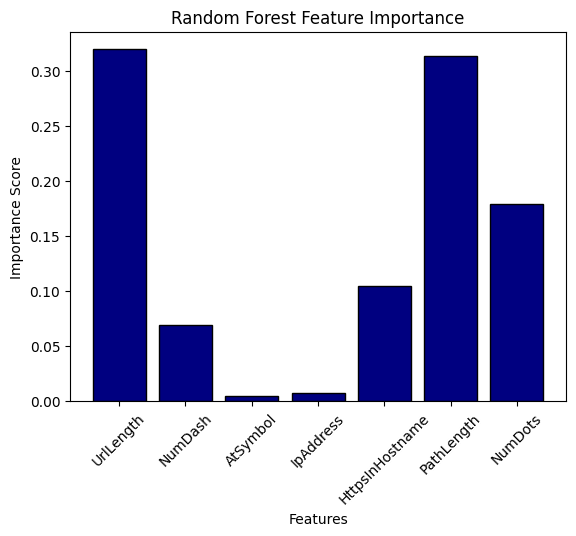

In [ ]:
#1. Random Forest Feature Importance
feat_importances = forest.feature_importances_
plt.bar(features,feat_importances, color='navy', edgecolor='black')
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=45)
plt.show()

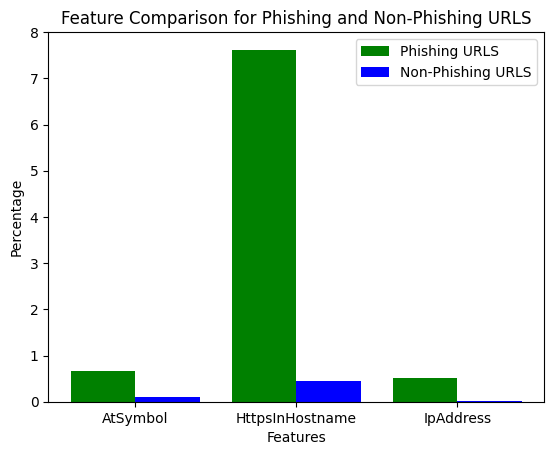

In [ ]:
#2. Percentage Bar Chart Based on Boolean Features

phishing_sum = df['Phising'].sum() #total num of phishing urls
non_phishing_sum = len(df[df['Phising'] == 0]) #total num of non-phishing urls

#calculations for percent of phishng and non phishing urls that contain at symbol
at_p_sum = len(df[(df['Phising'] == 1) & (df['AtSymbol'] == 1)])
at_noP_sum = len(df[(df['Phising'] == 0) & (df['AtSymbol'] == 1)])
at_p_percent = (at_p_sum / phishing_sum)*100
at_noP_percent = (at_noP_sum / non_phishing_sum)*100

#calculations for percent of phishng and non phishing urls that contain https in host name
https_p_sum = len(df[(df['Phising'] == 1) & (df['HttpsInHostname'] == 1)])
https_noP_sum = len(df[(df['Phising'] == 0) & (df['HttpsInHostname'] == 1)])
https_p_percent = (https_p_sum / phishing_sum)*100
https_noP_percent = (https_noP_sum / non_phishing_sum)*100

#calculations for percent of phishng and non phishing urls that contain ip address
ip_p_sum = len(df[(df['Phising'] == 1) & (df['IpAddress'] == 1)])
ip_noP_sum = len(df[(df['Phising'] == 0) & (df['IpAddress'] == 1)])
ip_p_percent = (ip_p_sum / phishing_sum)*100
ip_noP_percent = (ip_noP_sum / non_phishing_sum)*100

#graph percentages as bar chart
x = ['AtSymbol', 'HttpsInHostname', 'IpAddress']
phish_percent = [at_p_percent, https_p_percent, ip_p_percent]
non_phish_percent = [at_noP_percent, https_noP_percent, ip_noP_percent]
x_axis = np.arange(len(x))

#formatting output/graph
plt.bar(x_axis - 0.2, phish_percent, 0.4, color='green', label='Phishing URLS')
plt.bar(x_axis + 0.2, non_phish_percent, 0.4, color='blue', label='Non-Phishing URLS')
plt.xticks(x_axis, x)
plt.xlabel("Features")
plt.ylabel("Percentage")
plt.title("Feature Comparison for Phishing and Non-Phishing URLS")
plt.legend()
plt.show()

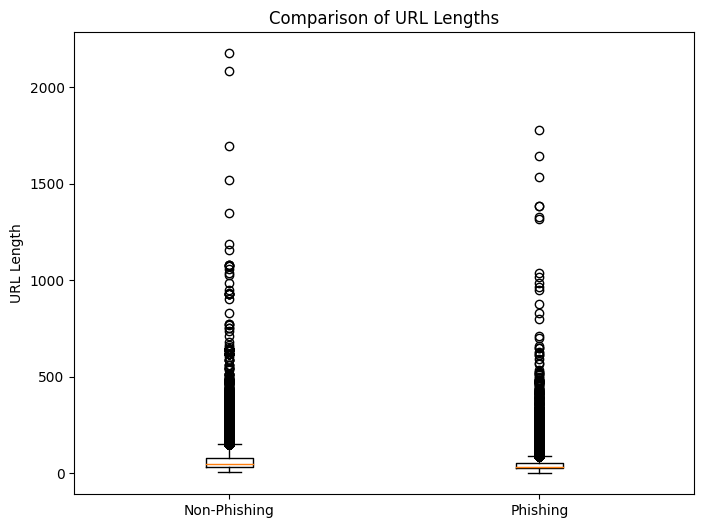

In [ ]:
#3. Box plot

phishing_url_lengths = df[df['Phising'] == 1]['UrlLength']
non_phishing_url_lengths = df[df['Phising'] == 0]['UrlLength']

# Plotting the boxplot
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([non_phishing_url_lengths, phishing_url_lengths], labels=['Non-Phishing', 'Phishing'])
ax.set_title('Comparison of URL Lengths')
ax.set_ylabel('URL Length')
plt.show()

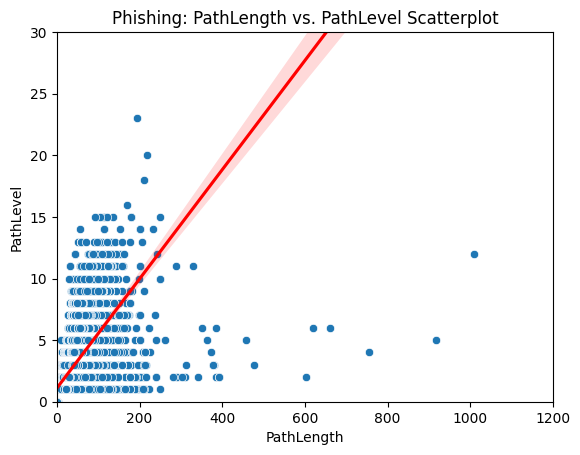

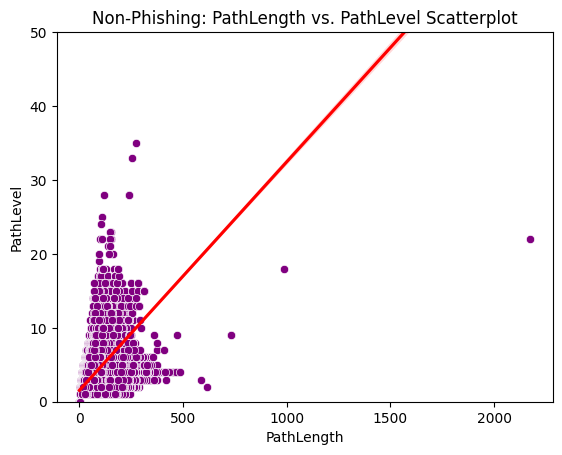

In [ ]:
#4. Correlation Scatter plot

phishing = df[df['Phising'] == 1]
non_phishing = df[df['Phising'] == 0]

#for phishing
sns.scatterplot(x='PathLength', y='PathLevel', data=phishing)
plt.title('Phishing: PathLength vs. PathLevel Scatterplot')
sns.regplot(x='PathLength', y='PathLevel', data=phishing, scatter=False, color='red')
plt.xlabel('PathLength')
plt.ylabel('PathLevel')
plt.ylim(0,30)
plt.xlim(0,1200)
plt.show()

#for non phishing
sns.scatterplot(x='PathLength', y='PathLevel', data=non_phishing, color = 'purple')
plt.title('Non-Phishing: PathLength vs. PathLevel Scatterplot')
sns.regplot(x='PathLength', y='PathLevel', data=non_phishing, scatter=False, color='red')
plt.xlabel('PathLength')
plt.ylabel('PathLevel')
plt.ylim(0,50)
plt.show()

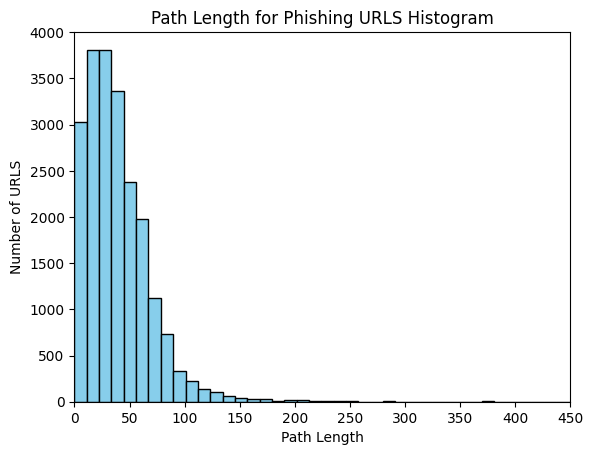

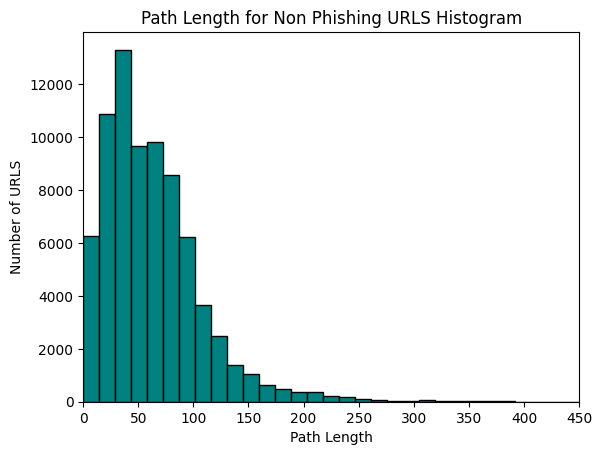

In [ ]:
#5. Histogram

phishing = df.loc[df['Phising'] == 1, 'PathLength']
non_phishing = df.loc[df['Phising'] == 0, 'PathLength']

#histogram for phishing data
plt.hist(phishing, bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Path Length')
plt.ylabel('Number of URLS')
plt.title('Path Length for Phishing URLS Histogram')
plt.xlim(0, 450) #customize range of x values shown
plt.show()

#histogram for non phishing data
plt.hist(non_phishing, bins=100, color='teal', edgecolor='black')
plt.xlabel('Path Length')
plt.ylabel('Number of URLS')
plt.title('Path Length for Non Phishing URLS Histogram')
plt.xlim(0, 450)
plt.show()

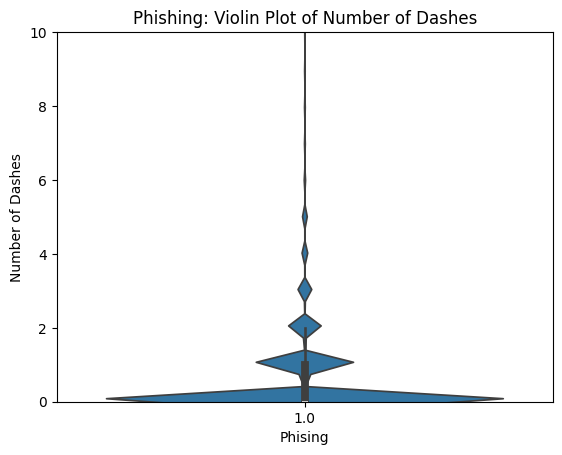

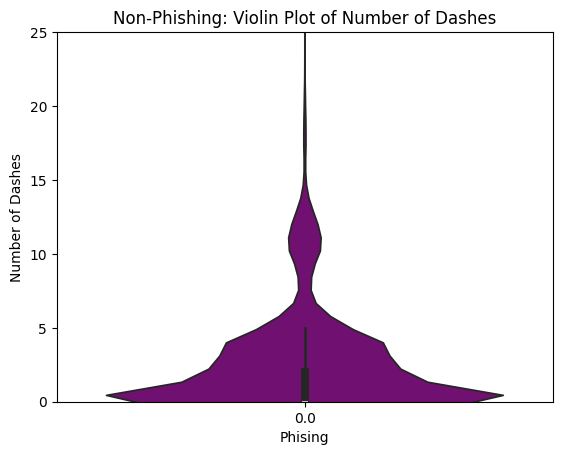

In [ ]:
#6. Violin Plot - number of dashes
phishing = df[df['Phising'] == 1]
non_phishing = df[df['Phising'] == 0]

#phishing violin plot
sns.violinplot(x='Phising', y='NumDash', data=phishing)
plt.title('Phishing: Violin Plot of Number of Dashes')
plt.ylabel('Number of Dashes')
plt.ylim(0,10)
plt.show()

#non-phishing violin plot
sns.violinplot(x='Phising', y='NumDash', data=non_phishing, color = 'purple')
plt.title('Non-Phishing: Violin Plot of Number of Dashes')
plt.ylabel('Number of Dashes')
plt.ylim(0,25)
plt.show()